<a href="https://colab.research.google.com/github/luffystxr/week2/blob/main/Forest_Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [2]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [3]:
# TO ensure the GPU is present
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is Available!')
else:
  print('GPU is Unavailable!')

GPU is Unavailable!


In [ ]:
import os
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# Set paths
original_base = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'
resized_base = '/kaggle/working/resized_wildfire_dataset'
target_size = (224, 224)

splits = ['train']
classes = ['fire','nofire']

for split in splits:
    for cls in classes:
        input_dir = os.path.join(original_base, split, cls)
        output_dir = os.path.join(resized_base, split, cls)
        os.makedirs(output_dir, exist_ok=True)

        for file in tqdm(os.listdir(input_dir), desc=f'{split}/{cls}'):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(input_dir, file)
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size, Image.Resampling.LANCZOS)
                    img.save(os.path.join(output_dir, file), format='JPEG', quality=90)
                except (UnidentifiedImageError, OSError) as e:
                    print(f"❌ Skipping {file} due to decompression or format error: {e}")


In [5]:
# Load and explore the dataset
train_dir = '/kaggle/working/resized_wildfire_dataset/train'
val_dir = '/kaggle/working/resized_wildfire_dataset/val'
test_dir = '/kaggle/working/resized_wildfire_dataset/test'

In [6]:
# List all the classes
classes = os.listdir(train_dir)
num_classes = len(classes)

# Display the class names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 2
Classes: ['fire', 'nofire']


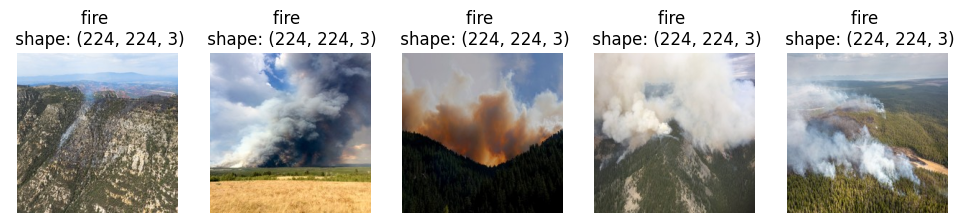

In [7]:
# Let's visualize the images in the dataset
plt.figure(figsize=(12, 10))
for i in range(5):
  class_path = os.path.join(train_dir, classes[0])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(f'{classes[0]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

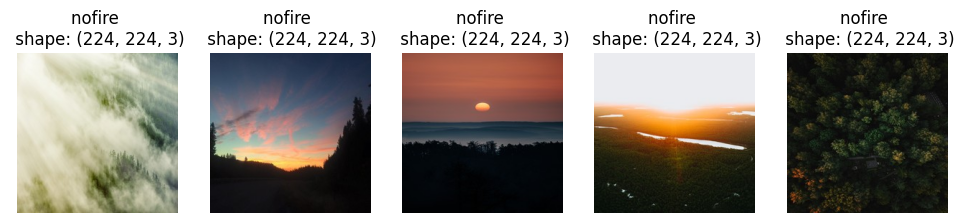

In [8]:
plt.figure(figsize=(12, 10))
for i in range(5):
  class_path = os.path.join(train_dir, classes[1])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(f'{classes[1]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [16]:
# Preprocessing
# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32 # there will be 32 images in a batch!

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [17]:
# map the indices
class_mapping = train_generator.class_indices
# print(class_mapping)
# Extract the class names
class_names = list(class_mapping.keys())
print("Class Names:", class_names)

Class Names: ['fire', 'nofire']


In [18]:
# Let's build the CNN Model
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]
)

In [19]:
from tensorflow.keras.optimizers import Adam  # ✅ Import this

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # ✅ Use capital A
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_accuracy',    # or 'val_loss'
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'                 # use 'min' if monitoring loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='max'
)


In [21]:
# Train with frozen base
history = model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6585 - loss: 0.6435 - val_accuracy: 0.7363 - val_loss: 0.5327 - learning_rate: 1.0000e-04
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7570 - loss: 0.5097 - val_accuracy: 0.7562 - val_loss: 0.4929 - learning_rate: 1.0000e-04
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7756 - loss: 0.4766 - val_accuracy: 0.7612 - val_loss: 0.4609 - learning_rate: 1.0000e-04
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7949 - loss: 0.4601 - val_accuracy: 0.7562 - val_loss: 0.4660 - learning_rate: 1.0000e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8043 - loss: 0.4243 - val_accuracy: 0.7811 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8157 - loss: 0.4055 - val_accuracy: 0.7786 - val_loss: 0.4327 - learning_rate: 1.0000e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8048 - loss: 0.4

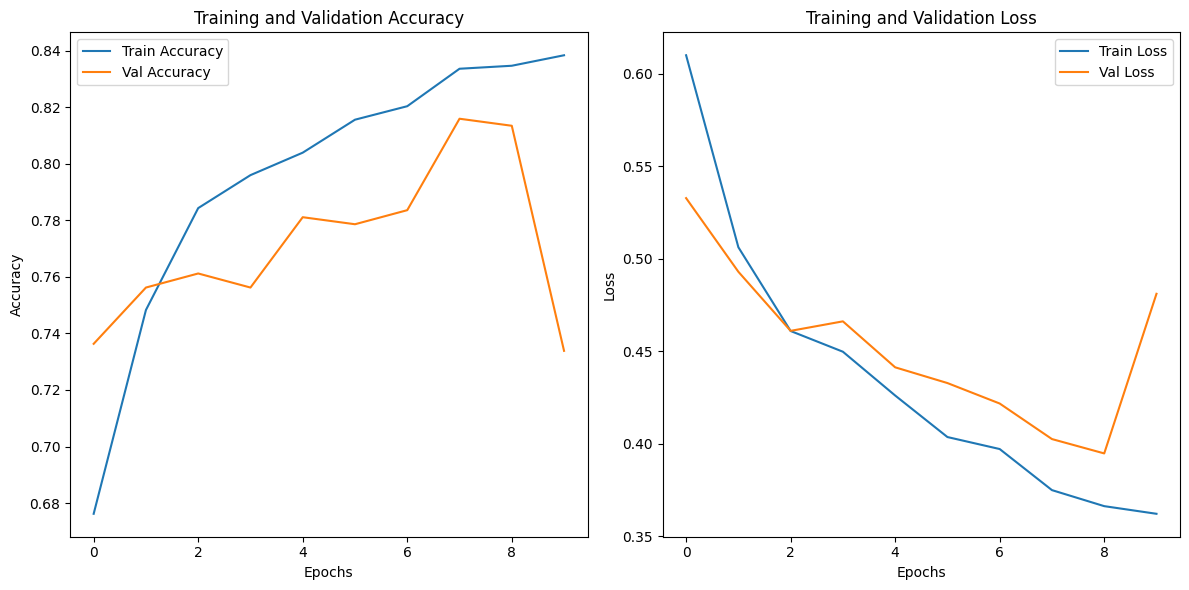

In [22]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.8087 - loss: 0.3955
Test Loss: 0.3836887776851654
Test Accuracy: 0.8170731663703918


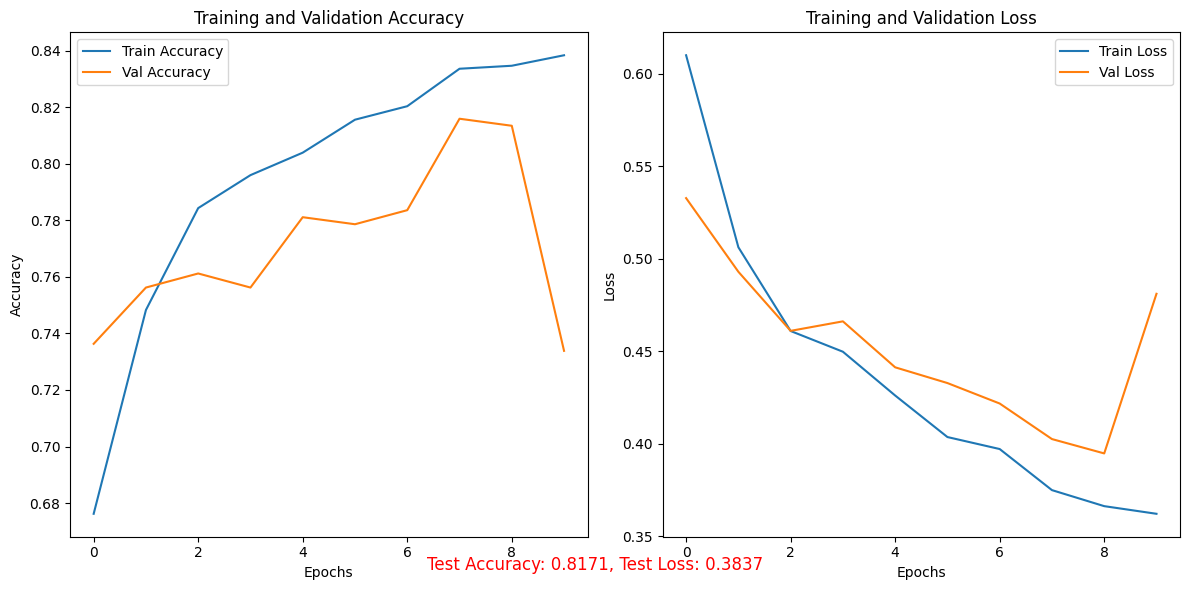

In [23]:
# Test the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Now plot the results for accuracy and loss
# If you want to visualize both training/validation and test results together

# Assuming you already have the history from model training
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Now you can add the test accuracy and loss as a final point
plt.figtext(0.5, 0.05, f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}",
            ha='center', va='center', fontsize=12, color='red')

# Show the plots
plt.tight_layout()
plt.show()


In [24]:
# Save the model
model.save('FFD.keras')

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the model
model = load_model('FFD.keras')

# Define class names
class_names = ['fire', 'nofire']  # Update based on your class labels

# Function to load, preprocess, and predict for an image
def predict_fire(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        predicted_class = class_names[1]
    else:
        predicted_class = class_names[0]

    return img, predicted_class

# Function to display images and predictions side by side
def display_images_with_predictions(image_directory, n_images=10):
    plt.figure(figsize=(20, 5))  # Adjust size to fit 10 images side by side

    # Get list of image file names from the directory
    file_names = [f for f in os.listdir(image_directory) if f.endswith('.jpg')]

    # Check if files are loaded correctly
    print(f"Found {len(file_names)} images.")

    if len(file_names) == 0:
        print("No images found in the directory. Please check the path or file extensions.")
        return

    # Display images in a grid of 10
    for i, img_name in enumerate(file_names[10:n_images+10]):
        img_path = os.path.join(image_directory, img_name)

        # Get image and predicted class
        img, predicted_class = predict_fire(img_path)

        # Plot image
        ax = plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        ax.imshow(img)
        ax.set_title(f'Prediction: {predicted_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Found 154 images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


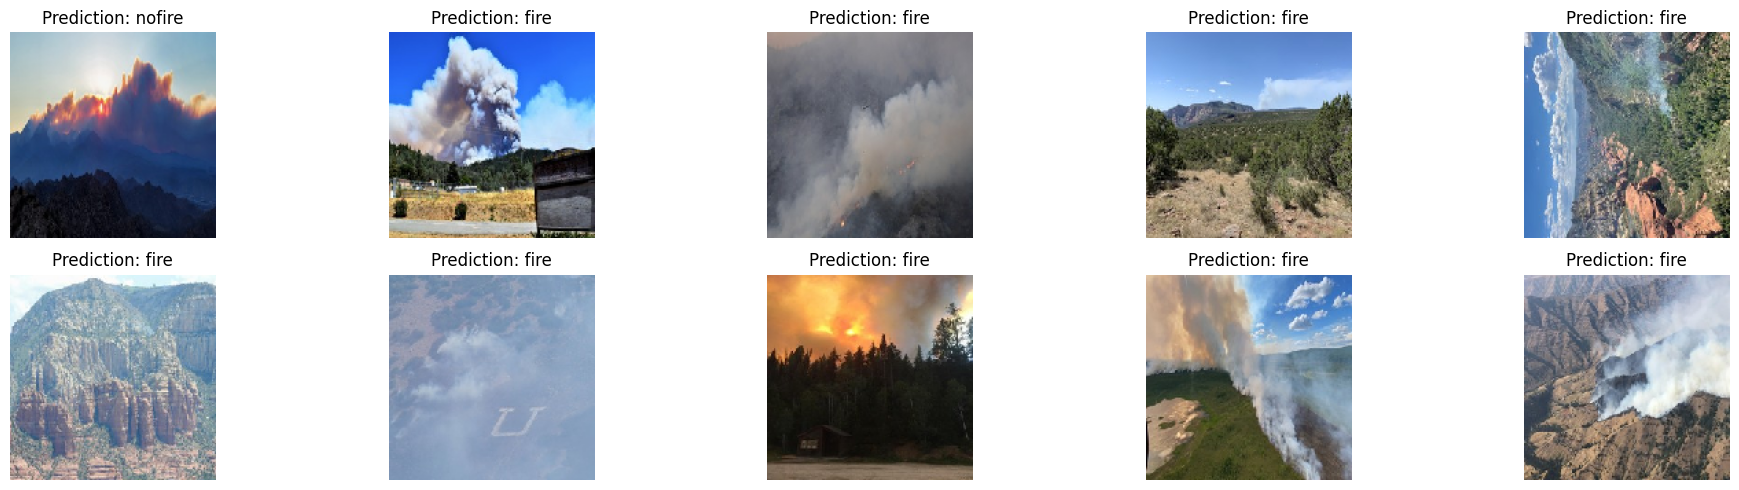

In [59]:
# testing_fire_images
image_directory = '/kaggle/working/resized_wildfire_dataset/test/fire'  # Replace with your directory path
display_images_with_predictions(image_directory)

Found 251 images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


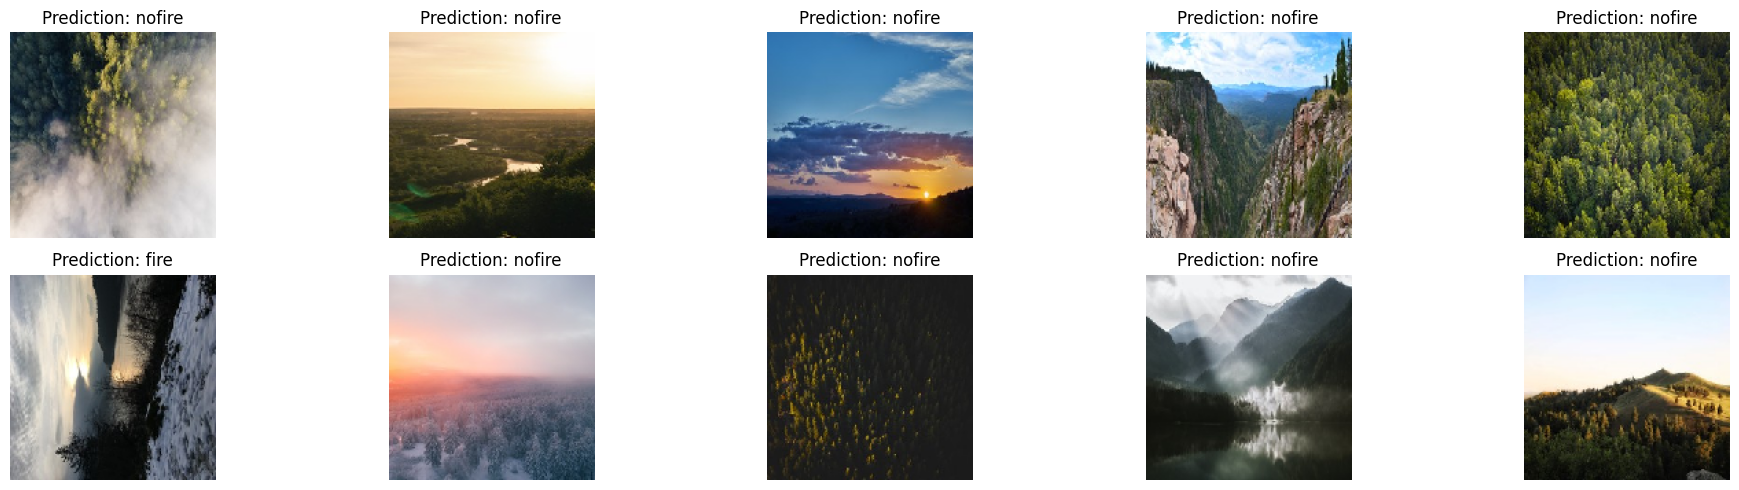

In [57]:
#testing_nofire_images
image_directory = '/kaggle/working/resized_wildfire_dataset/test/nofire'  # Replace with your directory path
display_images_with_predictions(image_directory)